In [37]:
import json
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
df_dataset = pd.DataFrame(columns=["text", "label"])

df_dataset.loc[0] = [1, 2]

print(df_dataset)

   text  label
0     1      2


In [26]:
# Load the datas and transform them into pd.Dataframe
df_dataset = pd.DataFrame(columns=["text", "label"])

with open("emotion_dataset.txt", "r") as datafile:
    i = 0
    for line in datafile:
        json_line = json.loads(line.strip())

        # Assert every label associated to a tweet belongs to the expected interval
        assert(0 <= json_line["label"] and json_line["label"] <= 5)

        df_dataset.loc[i] = [json_line["text"], json_line["label"]]

        i += 1

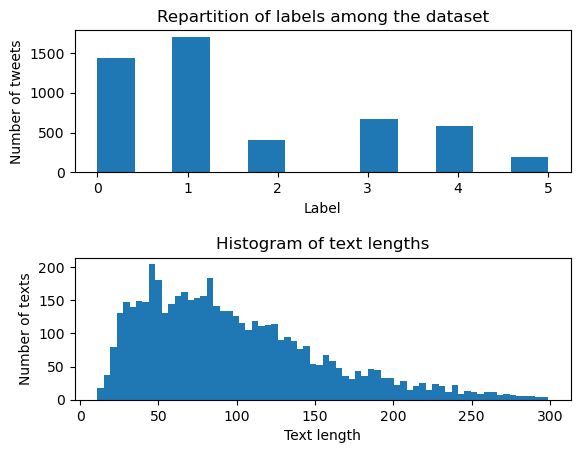

In [33]:
# Some funny plots
plt.figure()

plt.subplot(2,1,1)
plt.hist(df_dataset["label"].values, bins=12)
plt.xlabel("Label")
plt.ylabel("Number of tweets")
plt.title("Repartition of labels among the dataset")

plt.subplot(2,1,2)
plt.hist([len(text) for text in df_dataset["text"].values], bins=70)
plt.xlabel("Text length")
plt.ylabel("Number of texts")
plt.title("Histogram of text lengths")

plt.subplots_adjust(hspace=0.6)

plt.show()

In [55]:
X = df_dataset["text"]
y = df_dataset["label"]

# Transform the datas into suitable format for machine learning
nlp = spacy.load("en_core_web_sm")
lemmatized_texts = []

for index, row in df_dataset.iterrows():
    text = row["text"]

    # Sentence lemmatization
    doc = nlp(text)
    lemmatized_texts.append(" ".join([token.lemma_ for token in doc]))

df_dataset["lemmatized_text"] = lemmatized_texts
df_dataset.to_csv("df_emotion_dataset.csv")

# Create a CountVectorizer Object
vectorizer = CountVectorizer()
# Fit and transform the corpus
X = vectorizer.fit_transform(X)

# Split the dataset into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=12)


/home/alexis-le-s/miniconda3/envs/int_syst/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
# Charger le modèle linguistique de spaCy
nlp = spacy.load("en_core_web_sm")

# Chemin vers le fichier
file_path = "emotion_dataset.txt"

# Lecture et lemmatisation
lemmatized_data = []

with open(file_path, "r", encoding="utf-8") as file:
    i=0
    for line in file:
        if i < 5:
            # Charger chaque ligne comme un objet JSON
            record = json.loads(line.strip())
            
            # Analyse de la phrase avec spaCy
            doc = nlp(record["text"])
            
            # Lemmatisation de chaque mot
            lemmatized_text = " ".join([token.lemma_ for token in doc])
            
            # Ajouter la phrase lemmatisée au résultat
            record["lemmatized_text"] = lemmatized_text
            lemmatized_data.append(record)

            i+=1
        else:
            break

# Afficher les données avec lemmatisation
for entry in lemmatized_data:
    print(f"Original: {entry['text']}, Lemmatized: {entry['lemmatized_text']}, Label: {entry['label']}")


Original: i didnt feel humiliated, Lemmatized: I do not feel humiliated, Label: 0
Original: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake, Lemmatized: I can go from feel so hopeless to so damned hopeful just from be around someone who care and be awake, Label: 0
Original: im grabbing a minute to post i feel greedy wrong, Lemmatized: I m grab a minute to post I feel greedy wrong, Label: 3
Original: i am ever feeling nostalgic about the fireplace i will know that it is still on the property, Lemmatized: I be ever feel nostalgic about the fireplace I will know that it be still on the property, Label: 2
Original: i am feeling grouchy, Lemmatized: I be feel grouchy, Label: 3
